### The order of the project:

1. The correlation matrix of the features. 
2. The relationship between the features and the rate.
3. Some examples of the sarcasm detection, but not going into detail of the method.
4. Regression methods to predict the rate of the review.
5. Other more advanced regression models to improve the result.
6. Using the RMSE to evaluate the models and giving the best weight of variables.

In [327]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [5]:
with open ('review_sentiment_score_updated.csv', 'r') as review:
    df = pd.read_csv(review, index_col='index')
    df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
for i in range(len(df)):
    df.loc[i,'avg_pos'] = df.loc[i,['vader_pos', 'senticnet_pos', 'pattern_pos']].mean()
    df.loc[i,'avg_neg'] = df.loc[i,['vader_neg', 'senticnet_neg', 'pattern_neg']].mean()
    df.loc[i,'avg_sentiment'] = df.iloc[i,3:9].mean()

In [7]:
np.random.seed(23)

In [8]:
# remove some outliers that using many negative words but the rate is very positive
# those points would have serious influence on the prediction model.
for i in range(len(df.index)):
    pos = df.loc[i,'avg_pos']
    sentiment = df.loc[i,'avg_sentiment']
    rate = df.loc[i,'rate']
    if sentiment < 0 and rate >5:
        df.loc[i, 'classes'] = 'noneed'
    elif pos < 0.25 and rate >5:
        df.loc[i, 'classes'] = 'noneed'
    elif sentiment > 0 and rate <5:
        df.loc[i, 'classes'] = 'noneed'
    elif sentiment > 0.1 and rate ==1:
        df.loc[i, 'classes'] = 'noneed'
    elif rate == 1 and np.random.binomial(2, 0.3):
        df.loc[i, 'classes'] = 'noneed'
    else:
        df.loc[i, 'classes'] = 'keep'

df_no_outlier = df[df.classes == 'keep']

In [9]:
import matplotlib.pyplot as plt

(array([1422., 1054., 1106.,  945., 1427.,  772., 1377., 1767., 1356.,
        1913.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

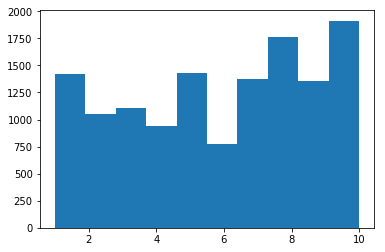

In [10]:
plt.hist(df_no_outlier.rate)
# the histagram of the distribution of the rate

In [283]:
df_no_outlier.head(10)

,movie,body,rate,vader_pos,vader_neg,senticnet_pos,senticnet_neg,pattern_pos,pattern_neg,avg_pos,avg_neg,avg_sentiment,classes
index,,,,,,,,,,,,,
0,10 Years,"Before I watched this movie, I read some revie...",10,0.237875,-0.079000,0.575030,-0.532500,0.355022,-0.500000,0.389309,-0.370500,0.009404,keep
1,10 Years,"In his directorial debut ""Ten Year"", Jamie Lin...",7,0.223286,-0.051250,0.452878,-0.453750,0.203770,-0.116250,0.293311,-0.207083,0.043114,keep
2,10 Years,'10 Years' is all about reunion of high school...,7,0.295000,-0.100000,0.502971,-0.630000,0.302272,-0.093333,0.366747,-0.274444,0.046152,keep
3,10 Years,¨Now the party can start!¨The film is about a ...,7,0.226742,-0.043609,0.548691,-0.677368,0.316566,-0.115972,0.364000,-0.278983,0.042508,keep
4,10 Years,Definitely worth seeing. I thoroughly enjoyed ...,9,0.388500,-0.013500,0.416000,-0.560000,0.260781,0.000000,0.355094,-0.191167,0.081964,keep
8,10 Years,"In ""Grosse Point Blank,"" John Cusack, a hit-ma...",5,0.105571,-0.103875,0.346324,-0.842667,0.162778,-0.111979,0.204891,-0.352840,-0.073975,keep
9,10 Years,I'll make this short. It was boring. Though it...,3,0.168714,-0.135429,0.520625,-0.651818,0.245908,-0.541667,0.311749,-0.442971,-0.065611,keep
10,10 Years,This film is about a group of high school clas...,3,0.126800,-0.135800,0.486059,-0.636667,0.356667,-0.285417,0.323175,-0.352628,-0.014726,keep
11,10 Years,I recently saw ten year at a prescreening even...,8,0.299000,0.000000,0.664125,-0.692857,0.461417,-0.050000,0.474847,-0.247619,0.113614,keep


### 1. The correlation matrix of the features.

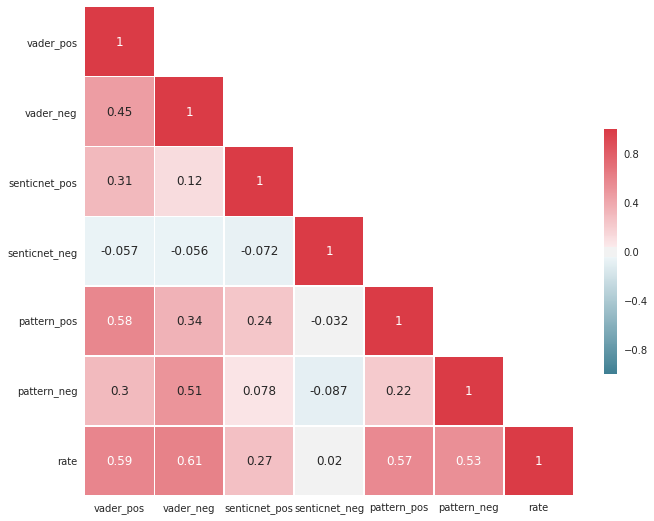

In [12]:
# get the correlation matrix
sns.set(style="white")

d = df_no_outlier[['vader_pos', 'vader_neg','senticnet_pos', 'senticnet_neg', 'pattern_pos', 'pattern_neg', 'rate']]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, +1)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  mask = mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### 2. The influence of the features to the rate.

In [251]:
import seaborn as sns; sns.set(color_codes=True)

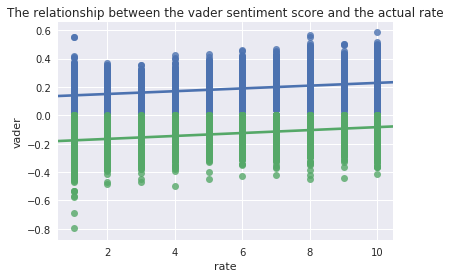

In [253]:
# The relationship between the vader sentiment score and the actual rate.
ax1 = sns.regplot(x="rate", y="vader_pos", data=df, x_jitter=.001, fit_reg=True)
ax1 = sns.regplot(x="rate", y="vader_neg", data=df, x_jitter=.001, fit_reg=True)
ax1.set(xlabel='rate', ylabel='vader', title = 'The relationship between the vader sentiment score and the actual rate')
plt.show() 

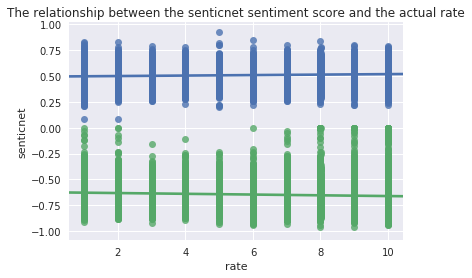

In [254]:
# The relationship between the senticnet sentiment score and the actual rate.
ax2 = sns.regplot(x="rate", y="senticnet_pos", data=df, x_jitter=.001, fit_reg=True)
ax2 = sns.regplot(x="rate", y="senticnet_neg", data=df, x_jitter=.001, fit_reg=True)
ax2.set(xlabel='rate', ylabel='senticnet', title = 'The relationship between the senticnet sentiment score and the actual rate')
plt.show()

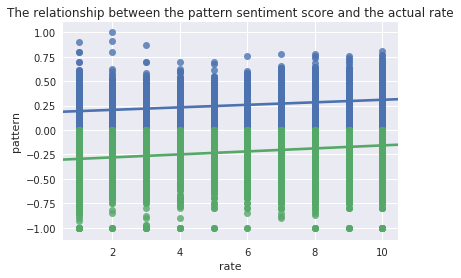

In [255]:
# The relationship between the pattern sentiment score and the actual rate.
ax = sns.regplot(x="rate", y="pattern_pos", data=df, x_jitter=.001, fit_reg=True)
ax = sns.regplot(x="rate", y="pattern_neg", data=df, x_jitter=.001, fit_reg=True)
ax.set(xlabel='rate', ylabel='pattern', title = 'The relationship between the pattern sentiment score and the actual rate' )
plt.show()

### 4. Regression methods to predict the rate of the review.

In [603]:
training, test = train_test_split(df_no_outlier, test_size=0.2, random_state=233)

In [328]:
# Initailly, I tried to take all the features into account for the linear regression model.

In [613]:
# fit the most only one sentiment score in the model.
x = training[['vader_pos', 'vader_neg']]
y = training.rate

In [614]:
# x.to_csv('training_x.csv')
# y.to_csv('training_y.csv')

In [615]:
x_test = test[['vader_pos', 'vader_neg']]
y_test = test.rate

In [616]:
# x_test.to_csv('test_x.csv')
# y_test.to_csv('test_y.csv')

In [617]:
reg = linear_model.LinearRegression(normalize=True)

In [618]:
reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [623]:
pre_y = reg.predict(x_test)

In [624]:
from sklearn import metrics

In [625]:
# the rmse of the model
mse = metrics.mean_squared_error(y_test, pre_y)
rmse = mse**0.5
print ( 'RMSE of the linear regression model is:\n', rmse)# this is the best linear regression model.

RMSE of the linear regression model is:
 2.125577626092725


In [626]:
# we can get the weight of each sentiment score.
reg.coef_

array([15.40251723, 18.4715009 ])

In [627]:
# to see if all the variables are significant to our model,
# the R-squared is 0.612, which is a acceptable value. It doesn't tell the good of fit.
# We are using RMSE to decide which model is better.
X = x
y = y

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     5145.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        17:23:56   Log-Likelihood:                -22911.
No. Observations:               10511   AIC:                         4.583e+04
Df Residuals:                   10508   BIC:                         4.585e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0324      0.088     56.967      0.0

### Then, we really want to improve the model, to get a less RMSE.
- First way is to use backwards regression.

In [628]:
# backwards regression
# using F score to decide which variables to be removed, and there is nothing more to be removed.
x = training[['vader_pos', 'vader_neg','senticnet_pos', 'senticnet_neg', 'pattern_pos', 'pattern_neg']]
y = training.rate
n = y.size

while True:
    nvars = x.shape[1] #total number of features before removing one
    q = 1 #1 var to remove
    p = nvars - q # remaining variables

    # get residual when using all features
    x2 = sm.add_constant(x)
    boston_model = sm.OLS(y,x2).fit()
    ssres0=boston_model.ssr

    # now get residule after removing 
    fvalues = []
    for i in range(1, nvars + 1):
        col = x2.columns[i]
        x2_cut = x2.drop(col, 1)
        model_cut = sm.OLS(y,x2_cut).fit()
        ssres1=model_cut.ssr
        F = (ssres1-ssres0)/q/(ssres0/(n-p-q-1))
        print("if removing column ", col," ssres_removed = ", ssres1," ssres_orig=",ssres0," F=", F)
        fvalues.append([col, F])  # stored [column name, F]
    sortedF = sorted(fvalues, key=lambda x: x[1])
    lowestF = sortedF[0][1]
    if lowestF < 1.07:
        print("removing column", sortedF[0][0])
        x = x.drop(sortedF[0][0], 1)
    else:
        print("STOP: no F-to-remove < 1.07 !!!")
        break

if removing column  vader_pos  ssres_removed =  39097.41634147927  ssres_orig= 36936.58006557843  F= 614.4971787253893
if removing column  vader_neg  ssres_removed =  41646.507269930255  ssres_orig= 36936.58006557843  F= 1339.405956552431
if removing column  senticnet_pos  ssres_removed =  37575.71246204575  ssres_orig= 36936.58006557843  F= 181.75604456539799
if removing column  senticnet_neg  ssres_removed =  37646.814001416256  ssres_orig= 36936.58006557843  F= 201.97585290233243
if removing column  pattern_pos  ssres_removed =  41657.66251042971  ssres_orig= 36936.58006557843  F= 1342.5782764044116
if removing column  pattern_neg  ssres_removed =  41997.99695965243  ssres_orig= 36936.58006557843  F= 1439.362360049635
STOP: no F-to-remove < 1.07 !!!


In [629]:
x = training[['vader_neg','pattern_pos', 'pattern_neg']]
y = training.rate

In [630]:
x_test = test[[ 'vader_neg', 'pattern_pos', 'pattern_neg']]
y_test = test.rate

In [631]:
X = x
y = y

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     4642.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        17:24:04   Log-Likelihood:                -22064.
No. Observations:               10511   AIC:                         4.414e+04
Df Residuals:                   10507   BIC:                         4.416e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.7911      0.074     77.954      

In [632]:
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [633]:
pre_y = reg.predict(x_test)

In [634]:
mse = metrics.mean_squared_error(y_test, pre_y)
rmse = mse**0.5
print ('The MRES of the model (after reducing variables:\n', rmse)

The MRES of the model (after reducing variables:
 1.9565965470125726


In [635]:
# different combinations of variables have been tried,
# however, non of them is better than the original model which contains all variables
# the best result is using all the variables 
# it gives a rmse: 1.851
x = training[['vader_pos', 'vader_neg','senticnet_pos', 'senticnet_neg', 'pattern_pos', 'pattern_neg']]
y = training.rate

In [636]:
x_test = test[['vader_pos', 'vader_neg','senticnet_pos', 'senticnet_neg', 'pattern_pos', 'pattern_neg']]
y_test = test.rate

In [637]:
reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [642]:
# to check if all the variables are significant
X = x
y = y

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     2764.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        17:24:53   Log-Likelihood:                -21519.
No. Observations:               10511   AIC:                         4.305e+04
Df Residuals:                   10504   BIC:                         4.310e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.5009      0.169     26.606

In [643]:
p = reg.predict(x_test)

In [644]:
mse = metrics.mean_squared_error(y_test, p)
rmse = mse**0.5
print ('The best result from linear regression:\n', rmse)

The best result from linear regression:
 1.8510951038006431


In [645]:
reg.coef_# the best weight of the different sentiment score. 

array([ 7.7845598 , 12.01122916,  3.38411571,  2.27949562,  7.52491992,
        5.42335239])

- **Note:** To sum up, backwards regression and stepwise regression models have been tested. The best result is given by fitting all the sentiment scores to the model. And it gives the best RMSE, **1.851**.

### 5. Other regession method

#### Ridge regression

- Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares. It has a $\alpha$ parameter. Here, $\alpha \geq 0$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.

In [646]:
# after tunning the parameters, the best combination of the parameters is shown as below:
ridge = linear_model.Ridge (alpha = 1, tol = 0.001, solver='auto', fit_intercept=True, normalize=False)
ridge.fit(x,y)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [647]:
p = ridge.predict(x_test)

In [648]:
mse = metrics.mean_squared_error(y_test, p)
rmse = mse**0.5
print (rmse)

1.8505226993176866


In [649]:
# using the RidgeCV function, we could get a better alphas value.
regcv = linear_model.RidgeCV(alphas=np.linspace(0.001, 2, 10), cv = 10)
regcv.fit(x,y)       

RidgeCV(alphas=array([1.00000e-03, 2.23111e-01, 4.45222e-01, 6.67333e-01, 8.89444e-01,
       1.11156e+00, 1.33367e+00, 1.55578e+00, 1.77789e+00, 2.00000e+00]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [650]:
p = ridge.predict(x_test)

In [651]:
a = metrics.mean_squared_error(y_test, p)
a**0.5

1.8505226993176866

In [652]:
regcv.alpha_

0.22311111111111112

### Theil-Sen Regressor

The algorithm calculates least square solutions on subsets with size n_subsamples of the samples in X. Any value of n_subsamples between the number of features and samples leads to an estimator with a compromise between robustness and efficiency. Since the number of least square solutions is “n_samples choose n_subsamples”, it can be extremely large and can therefore be limited with max_subpopulation. If this limit is reached, the subsets are chosen randomly. In a final step, the spatial median (or L1 median) is calculated of all least square solutions.

In [653]:
reg = linear_model.TheilSenRegressor(n_jobs=-1, verbose=True, n_subsamples=2000)

In [654]:
reg.fit(x,y)

Breakdown point: 0.0002806130013802699
Number of samples: 10511
Tolerable outliers: 2
Number of subpopulations: 10000


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=-1, n_subsamples=2000,
         random_state=None, tol=0.001, verbose=True)

In [655]:
p = reg.predict(x_test)

In [656]:
a = metrics.mean_squared_error(y_test, p)
a**0.5

1.85117125686358

In [657]:
reg.score(x,y)

0.6122638226590609

## 6. Evaluation of the models